If the notebook is being run on the local system, please download the necessary files from the drive link provided in the code cells.</br>
<font color="blue">*Please change the links accordingly*</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import csv
from torch import nn
import pandas as pd
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ZeroPad2d
from torchvision import transforms, datasets
import shutil
from sklearn.metrics import auc, confusion_matrix, classification_report
import seaborn as sns
from scipy.optimize import brentq
from scipy.interpolate import interp1d 
import random
import os
#from pycm import *

In [ ]:
# Point 3's data is accessed via the zip file stored in the drive
# This zip file is transferred to the disk of the google colab, 
# because accessing it from the disk directly is faster than
# accessing the images from the drive

#Link to the zip file: https://drive.google.com/file/d/1bWjl661Kk3xa8MmdXKHAwsr48080LaQG/view?usp=sharing
!cp -r "/content/drive/MyDrive/MIDAS/Point3/mnistTask.zip" "/content/mnistTask.zip"
!unzip mnistTask.zip

In [ ]:
#To create a csv of all the image filepaths
path = "/content/mnistTask" #Path to unzipped folder with images
df = pd.DataFrame(columns=['FilePath', 'Label'])
i = 0
for (root,dirs,files) in os.walk(path, topdown=True):
    if i == 0:
      i = 1
      continue

    #print(root)
    files_path = [root + '/' + i for i in files] #Add appropriate file path before image filepath
    label = [int(root[-1:])] * len(files_path) 

    x = pd.DataFrame(list(zip(files_path, label)), columns=['FilePath', 'Label'])
    df = df.append(x)

df.head()

,FilePath,Label
0,/content/mnistTask/4/image_044548.jpg,4
1,/content/mnistTask/4/image_002442.jpg,4
2,/content/mnistTask/4/image_007931.jpg,4
3,/content/mnistTask/4/image_048121.jpg,4
4,/content/mnistTask/4/image_025016.jpg,4


In [ ]:
print(df.shape)
df['Label'].value_counts()

(60000, 2)


5    6139
8    6129
6    6037
3    6037
2    6009
9    5994
0    5980
7    5954
4    5914
1    5807
Name: Label, dtype: int64

In [ ]:
df.to_csv('/content/drive/MyDrive/MIDAS/Point3/dataset_p3.csv', index=None) #Please change link accordingly

In [ ]:
#All images are resized to 200 * 200 and have been normalized
def _preprocess(image):
    # Preprocessing step
    img_transform = transforms.Compose([
        transforms.ToPILImage(),              #Conversion to PIL Image
        transforms.Resize((200, 200)),        #Resize image to 200 * 200
        transforms.ToTensor(),                #Conversion to Tensor
        transforms.Normalize((0.5, ), (0.5,)) #Normalise Image
    ])
    return img_transform(image)

In [ ]:
class Images_test(Dataset):
  def __init__(self, df):
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE)
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1]

    return image1, torch.from_numpy(np.array([label], dtype=np.float32)), self.data.iloc[index, 0]

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MIDAS/Point3/dataset_p3.csv") #please change link accordingly
df = df.sample(frac = 1)
df.head()

,FilePath,Label
19801,/content/mnistTask/6/image_003224.jpg,2
39081,/content/mnistTask/7/image_000375.jpg,2
27945,/content/mnistTask/6/image_012998.jpg,3
56391,/content/mnistTask/1/image_022465.jpg,6
57913,/content/mnistTask/5/image_006924.jpg,8


In [ ]:
valid_dataset = Images_test(df)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

val_iter = iter(val_loader)
images1, labels, fpath = val_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))
print('File path shape on batch size = {}'.format(fpath))

images shape on batch size = torch.Size([1, 1, 200, 200])
labels shape on batch size = torch.Size([1, 1])
File path shape on batch size = ('/content/mnistTask/8/image_051355.jpg',)


In [ ]:
class smallModel(nn.Module):
  def __init__(self):
    super(smallModel, self).__init__()
    
    self.zp1 = nn.ZeroPad2d(1)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.mp1 = nn.MaxPool2d(kernel_size=2)
    self.dp = nn.Dropout(p=0.3)

    self.zp2 = nn.ZeroPad2d(1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.mp2 = nn.MaxPool2d(kernel_size=2)
    #self.dp = nn.Dropout(p=0.3)

    self.zp3 = nn.ZeroPad2d(1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.mp3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.mp4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.mp5 = nn.MaxPool2d(kernel_size=2)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(512 * 6 * 6, 9216)
    self.fc2 = nn.Linear(9216, 4096)
    self.fc3 = nn.Linear(4096, 1024)
    self.fc4 = nn.Linear(512 * 6 * 6, 10)

    self.row_emb = nn.Parameter(torch.rand(64, 512 // 2))
    self.col_emb = nn.Parameter(torch.rand(64, 512 // 2))

  def forward(self, x):
    x = self.dp(self.relu(self.conv1(x)))
    x = self.mp1(x)

    x = self.dp(self.relu(self.conv2(x)))
    x = self.mp2(x)

    x = self.dp(self.relu(self.conv3(x)))
    x = self.mp3(x)

    x = self.dp(self.relu(self.conv4(x)))
    x = self.mp4(x)

    x = self.dp(self.relu(self.conv5(x)))
    x = self.mp5(x)

    H = x.shape[-1]
    W = x.shape[-2]
    pos = torch.cat([self.col_emb[:W].unsqueeze(0).repeat(H, 1, 1), self.row_emb[:H].unsqueeze(1).repeat(1, W, 1),], dim=-1).flatten(0, 1).unsqueeze(1)

    x = x.flatten(2).permute(2, 0, 1)

    x = self.transformer_encoder(pos + x)

    x = x.permute(1, 2, 0)
    x = torch.reshape(x, ((x.shape)[0], 512 * 36))

    #x = self.relu(self.fc1(x))
    #x = self.relu(self.fc2(x))
    #x = self.relu(self.fc3(x))
    x = self.fc4(x)
  
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smallModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 1e-4)

#Link for the model: https://drive.google.com/file/d/1-pztQxLKFb_ZLc0f9tCDXhKgGURJp-4V/view?usp=sharing
checkpoint = torch.load("/content/drive/MyDrive/MIDAS/Point2/trained_scratch_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_last = checkpoint['epoch']
loss = checkpoint['loss']

print(loss)
print(epoch_last)

tensor(2.4934e-05, device='cuda:0', requires_grad=True)
20


In [ ]:
#Evaluation begins
i = 0
l1 = []
l2 = []
vcorrect = 0


model.eval()
#test_loader = DataLoader(valset, batch_size=1, shuffle=True)
for batch, (img, target, fpath) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    print(batch)
    output = model(img)
    
    _,pred = torch.max(output, dim=1)
    l1.append(str(fpath)[2:-3])
    l2.append(pred.item())


df_label = pd.DataFrame(columns=["FilePath", "Label"])
df_label["FilePath"] = l1
df_label["Label"] = l2
df_label.head()

0
1
2
3
4


,FilePath,Label
0,/content/mnistTask/0/image_059019.jpg,7
1,/content/mnistTask/9/image_040100.jpg,3
2,/content/mnistTask/1/image_057156.jpg,5
3,/content/mnistTask/6/image_005598.jpg,5
4,/content/mnistTask/1/image_010733.jpg,8


In [ ]:
df_label.to_csv('/content/drive/MyDrive/MIDAS/Point3/dataset_p3.csv', index=None)

5


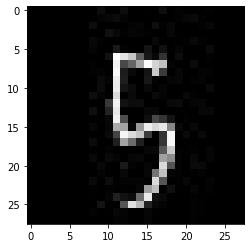

In [ ]:
print(df_label.iloc[2, 1])
img = cv.imread(df_label.iloc[2, 0], cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = "gray") #Predicted: 5